In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import scipy.sparse as sparse
pv.set_jupyter_backend("trame")

In [2]:
points_list = []
n = 51
x = np.linspace(0, 2, n)
y = x.copy()
for i in range(n):
    for j in range(n):
        xi = x[i]
        yj = y[j]
        if xi < 0 or yj < 0 or xi + yj > 2:
            continue
            pass
        else:
            points_list.append([xi, yj, 0])
            pass
        pass
    pass
points = pv.PolyData(points_list)

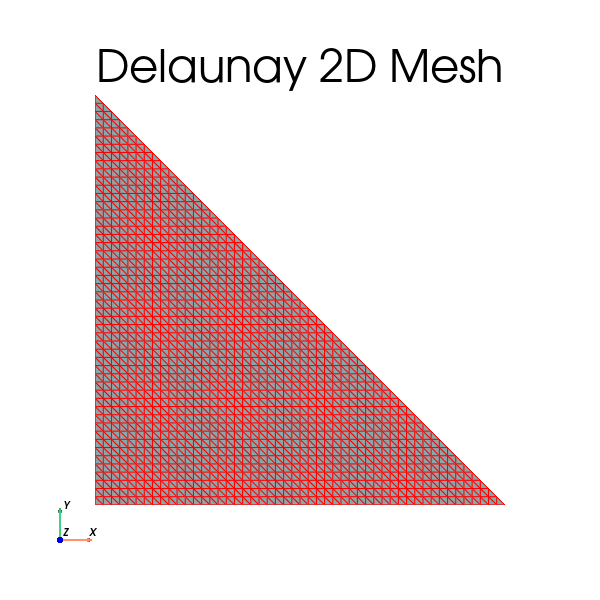

In [3]:
mesh = points.delaunay_2d()
plotter = pv.Plotter(notebook=True, window_size=(600, 600))
plotter.add_mesh(mesh, show_edges=True, edge_color="r")
plotter.add_title("Delaunay 2D Mesh")
plotter.add_axes()
plotter.camera_position = "xy"
plotter.screenshot("images/problem1_delaunay2d_mesh.png")
plotter.show(jupyter_backend="static", cpos="xy")

In [4]:
def insertDict(sparse_dict, i, j, value):
    if (i, j) in sparse_dict:
        sparse_dict[(i, j)] += value
        pass
    else:
        sparse_dict[(i, j)] = value
        pass
    pass

def getKMatrix(mesh):
    sparse_dict = dict()
    for i_cell in range(mesh.n_cells):
        cell = mesh.get_cell(i_cell)
        id1, id2, id3 = cell.point_ids
        x1, y1, _ = cell.points[0]
        x2, y2, _ = cell.points[1]
        x3, y3, _ = cell.points[2]
        a2 = 2 * np.linalg.det(np.array([
            [1, x1, y1],
            [1, x2, y2],
            [1, x3, y3]
        ]))
        k11 = (x2 - x3)**2 + (y2 - y3)**2;
        k12 = (x1 - x3) * (-x2 + x3) + (y1 - y3) * (-y2 + y3);
        k13 = (x1 - x2) * (x2 - x3) + (y1 - y2) * (y2 - y3);
        k22 = (x1 - x3)**2 + (y1 - y3)**2;
        k23 = (x1 - x2) * (-x1 + x3) + (y1 - y2) * (-y1 + y3);
        k33 = (x1 - x2)**2 + (y1 - y2)**2;
        insertDict(sparse_dict, id1, id1, k11 / a2)
        insertDict(sparse_dict, id1, id2, k12 / a2)
        insertDict(sparse_dict, id1, id3, k13 / a2)
        insertDict(sparse_dict, id2, id1, k12 / a2)
        insertDict(sparse_dict, id2, id2, k22 / a2)
        insertDict(sparse_dict, id2, id3, k23 / a2)
        insertDict(sparse_dict, id3, id1, k13 / a2)
        insertDict(sparse_dict, id3, id2, k23 / a2)
        insertDict(sparse_dict, id3, id3, k33 / a2)
        pass
    mat_i = []
    mat_j = []
    mat_v = []
    for (i, j), value in sparse_dict.items():
        mat_i.append(i)
        mat_j.append(j)
        mat_v.append(value)
        pass
    return sparse.coo_matrix((mat_v, (mat_i, mat_j)))
    pass

In [5]:
mat_k = getKMatrix(mesh)

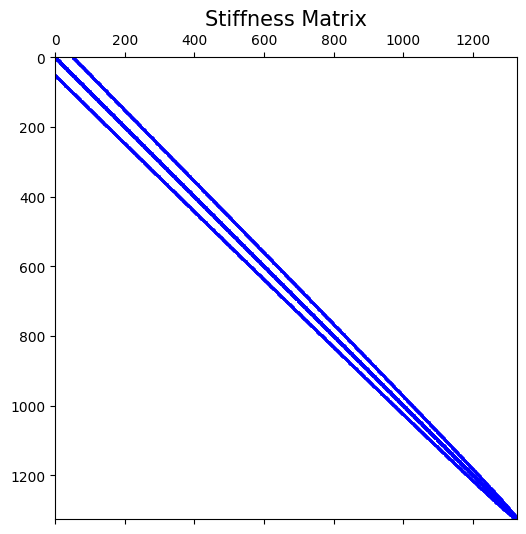

In [6]:
plt.figure(figsize=(6, 6), facecolor="w")
plt.spy(mat_k.toarray(), markersize=1, color="b")
plt.title("Stiffness Matrix", fontsize=15)
plt.savefig("images/problem1_stiffness_matrix.png")
plt.show()

In [7]:
def neumannNode(x, y):
    return np.abs(x) < 1e-9
    pass

def dirichletNode(x, y):
    return np.abs(y) < 1e-9
    pass

def neumannBoundary(mesh, neumann_value):
    f = np.zeros(mesh.n_points)
    for i_cell in range(mesh.n_cells):
        cell = mesh.get_cell(i_cell)
        node_list = []
        for node_id in cell.point_ids:
            x, y, _ = mesh.points[node_id]
            if neumannNode(x, y):
                node_list.append(node_id)
                pass
            pass
        if len(node_list) == 2:
            edge_length = np.linalg.norm(mesh.points[node_list[0]] - mesh.points[node_list[1]])
            f[node_list[0]] += neumann_value * edge_length / 2
            f[node_list[1]] += neumann_value * edge_length / 2
            pass
        pass
    return f
    pass

def dirichletBoundary(mesh):
    ids = []
    for i in range(mesh.n_points):
        x, y, _ = mesh.points[i]
        if dirichletNode(x, y):
            ids.append(i)
            pass
        pass
    return np.array(ids, dtype=int)
    pass

In [8]:
vec_f = neumannBoundary(mesh, 1)
dirichlet_ids = dirichletBoundary(mesh)

In [9]:
tosolve_ids = np.setdiff1d(np.arange(mesh.n_points), dirichlet_ids)
u = np.zeros(mesh.n_points)
u[dirichlet_ids] = 0
f = vec_f - mat_k.dot(u)
tosolve_mat_k = mat_k.tocsr()[np.ix_(tosolve_ids, tosolve_ids)]
tosolve_f = f[tosolve_ids]
u[tosolve_ids] = sparse.linalg.spsolve(tosolve_mat_k, tosolve_f)

In [10]:
mesh.point_data["u"] = u

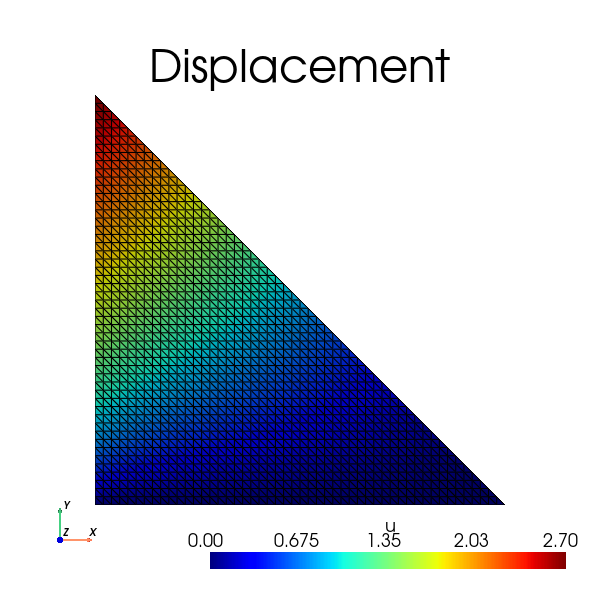

In [11]:
plotter = pv.Plotter(notebook=True, window_size=(600, 600))
plotter.add_mesh(mesh, scalars="u", edge_color="k", show_edges=True, cmap="jet", show_scalar_bar=True)
plotter.add_title("Displacement")
plotter.add_axes()
plotter.camera_position = "xy"
plotter.screenshot("images/problem1_displacement.png")
plotter.show(jupyter_backend="static", cpos="xy")